# Etude globale de l’accélération AMP

In [7]:
import os
import json
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

In [8]:
import sys
sys.path.append("..")

from amp.utils.urls import generate_canonical_from_amp, get_domain_from_url, generate_amp_from_cache, generate_cache_from_amp, generate_amp_from_viewer
from amp.utils.parse_lighthouse_audits import process_all_files

On distingue 4 URLs différentes pour une page web AMP :

- L’URL originale du site non AMP (e.g. https://www.ouest-france.fr/politique/gouvernement/remaniement/le-dessin-de-chaunu-le-remaniement-42a2b8a4-fbd3-11ec-a4aa-17494c3bd71d )
- L’URL de la page AMP du site stockée sur son serveur (e.g. https://amp.ouest-france.fr/politique/gouvernement/remaniement/le-dessin-de-chaunu-le-remaniement-42a2b8a4-fbd3-11ec-a4aa-17494c3bd71d)
- L’URL de la page AMP du site en cache sur le serveur Google (e.g. https://amp-ouest--france-fr.cdn.ampproject.org/c/s/amp.ouest-france.fr/politique/gouvernement/remaniement/le-dessin-de-chaunu-le-remaniement-42a2b8a4-fbd3-11ec-a4aa-17494c3bd71d)
- L’URL de la page AMP telle qu’elle apparaîtra à l’utilisateur (iframe) (e.g. https://www.google.com/amp/s/amp.ouest-france.fr/politique/gouvernement/remaniement/le-dessin-de-chaunu-le-remaniement-42a2b8a4-fbd3-11ec-a4aa-17494c3bd71d)

Le contenu est le même sur la page AMP Base et AMP Cache, la seule différence est la localisation sur les serveurs de cache ou non.

Tous les tests ont été effectués avec Lighthouse, développé par Google.

## 0. Données brutes

In [9]:
folder_name = os.path.join(os.getcwd(), "../data/2022-08-01-12:09:16")
audits = process_all_files(folder_name)
audits

url run       fcp  \
133  https://amp-allodocteurs-fr.cdn.ampproject.org...   1  2353.522   
152  https://amp-allodocteurs-fr.cdn.ampproject.org...   2  2370.893   
311  https://amp-allodocteurs-fr.cdn.ampproject.org...   3  1975.080   
242  https://amp-allodocteurs-fr.cdn.ampproject.org...   4  2440.158   
274  https://amp-allodocteurs-fr.cdn.ampproject.org...   5  2471.619   
..                                                 ...  ..       ...   
247  https://www.tf1info.fr/sante/covid-19-pass-san...   1  1135.794   
69   https://www.tf1info.fr/sante/covid-19-pass-san...   2  1114.538   
157  https://www.tf1info.fr/sante/covid-19-pass-san...   3  1261.682   
1    https://www.tf1info.fr/sante/covid-19-pass-san...   4  1249.509   
222  https://www.tf1info.fr/sante/covid-19-pass-san...   5  1362.769   

           lcp        tti           si       cls    fid  score  cache    amp  
133  3045.8605  2648.3015  2921.786884  0.013008   64.0   0.91   True   True  
152  3326.8930  2782.8930  3271.485254  0.013008  206.0   0.88   True   True  
311  2548.2260  4211.0525  2876.485002  0.013008   70.0   0.94   True   True  
242  3319.1240  4817.5730  3307.421413  0.013008  185.0   0.84   True   True  
274  3348.4240  4545.2705  3602.106692  0.009927   62.0   0.86   True   True  
..         ...        ...          ...       ...    ...    ...    ...    ...  
247  1526.9110  7405.3130  1577.410299  0.000232  405.0   0.69  False  False  
69   1680.9540  7480.0670  2042.843066  0.000232  367.0   0.69  False  False  
157  2487.7460  7904.5830  1931.598711  0.006870  398.0   0.66  False  False  
1    2954.4030  7530.1195  1848.132902  0.006870  318.0   0.67  False  False  
222  2565.5960  7756.6685  1952.867074  0.006870  312.0   0.67  False  False  

[420 rows x 11 columns]

## 1. Pré-traitement des données

Dans un premier temps nous créons une variable `page_type` qui vaut 0, 2 ou 3 suivant le type de page (respectivement canonique, AMP servie par l'éditeur et AMP en cache).

In [10]:
audits["page_type"] = audits[["cache", "amp"]].apply(lambda x: x["cache"] + 2 * x["amp"], axis=1)

#### Ajout des URLs canoniques qui constituent notre "clé primaire"

In [11]:
audits.loc[~audits["amp"], "canonical"] = audits.loc[~audits["amp"], "url"]

In [ ]:
audits.loc[(audits["amp"] & ~audits["cache"]), "canonical"] = audits.loc[(audits["amp"] & ~audits["cache"]), 
                                                                         "url"].apply(generate_canonical_from_amp)

In [ ]:
audits.loc[(audits["amp"] & audits["cache"]), "canonical"] = audits.loc[(audits["amp"] & audits["cache"]),
                                                                        "url"].apply(generate_amp_from_cache)
audits.loc[(audits["amp"] & audits["cache"]), "canonical"] = audits.loc[(audits["amp"] & audits["cache"]), 
                                                                        "url"].apply(generate_canonical_from_amp)

In [14]:
audits = audits.set_index("url")

In [15]:
audits.loc["https://amp.france24.com/fr/moyen-orient/20220731-liban-une-partie-des-silos-du-port-de-beyrouth-s-effondre-apr%C3%A8s-un-incendie", "canonical"] = "https://www.france24.com/fr/moyen-orient/20220731-liban-une-partie-des-silos-du-port-de-beyrouth-s-effondre-apr%C3%A8s-un-incendie"

In [16]:
audits.loc["https://amp.ouest-france.fr/faits-divers/incendie/un-nouvel-incendie-detruit-150-hectares-de-pins-dans-les-landes-b748c8af-32c9-4644-8988-9cb400a6c6c5", "canonical"] = "https://www.ouest-france.fr/faits-divers/incendie/un-nouvel-incendie-detruit-150-hectares-de-pins-dans-les-landes-b748c8af-32c9-4644-8988-9cb400a6c6c5"

Nous vérifions ensuite que toutes les URLs canoniques ont bien été trouvées.

In [17]:
len(audits[audits["canonical"] == ""])

20

#### Moyenne sur les 5 runs

In [18]:
grouped_audits = audits.groupby("url")[["page_type", "fcp", "lcp", "tti", "si", "fid", "cls", "score"]].mean().sort_values("score")

In [19]:
grouped_audits["canonical"] = audits[audits["run"] == "1"].loc[grouped_audits.index]["canonical"]
grouped_audits["domain"] = grouped_audits["canonical"].apply(get_domain_from_url)

In [20]:
valid_canonical_urls = (grouped_audits.groupby("canonical")["score"].count() == 3)
grouped_audits = grouped_audits.reset_index().set_index("canonical").loc[valid_canonical_urls]
grouped_audits = grouped_audits.reset_index().set_index(["canonical", "page_type"]).sort_values(["canonical", "page_type"])

## 2. Comparaison de performance

### 2.1 Comparaison agrégée pour différentes métriques 

L’objectif est de comparer les performances des différents types de pages pour déterminer notamment quelle part de l’accélération observée est imputable à l‘utilisation d’un cache et quelle part aux limitations imposées par framework AMP. 

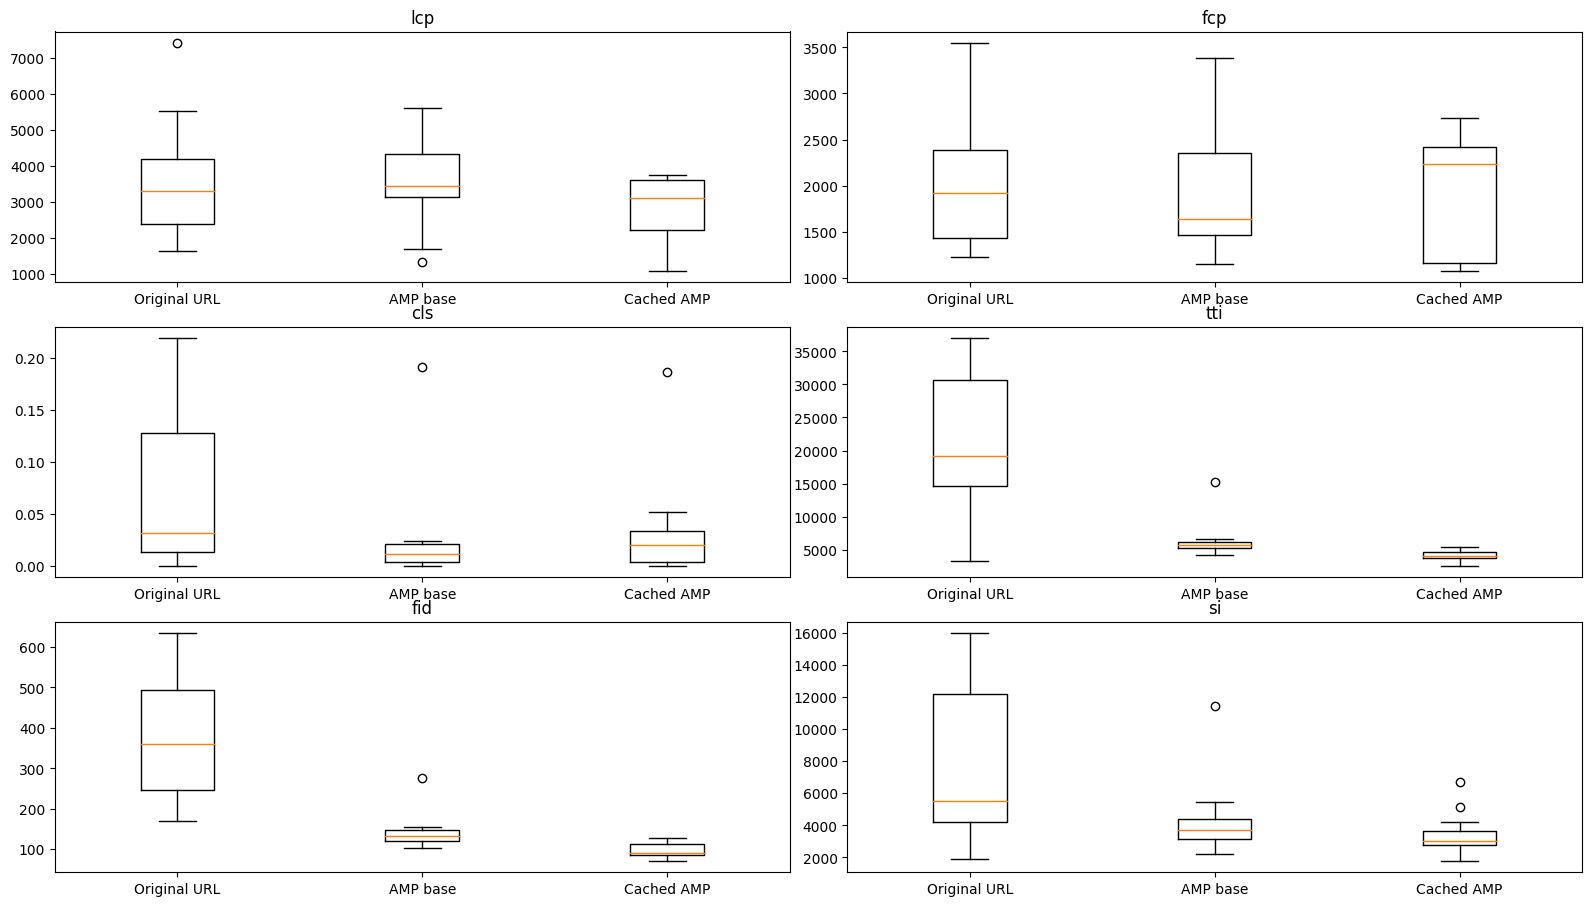

In [21]:
fig, ax = plt.subplots(3,2, figsize=(16, 9))
fig.tight_layout()
keys = ["lcp",  "cls", "fid", "fcp",  "tti", "si"]
for i in range(6):
    x, y = i % 3, i // 3
    ax[x,y].boxplot(grouped_audits.groupby("page_type")[keys[i]].apply(list).values, labels=["Original URL", "AMP base", "Cached AMP"])
    ax[x,y].set_title(keys[i])

In [22]:
grouped_audits = grouped_audits.reset_index()

In [23]:
grouped_audits["str_page_type"] = grouped_audits["page_type"].map({0: "Canonique (HTML)", 2: "AMP", 3: "AMP (cache)"})

In [24]:
alt.Chart(grouped_audits).mark_boxplot().encode(
    x=alt.X('str_page_type:O', title='Type de page', axis=alt.Axis(labelAngle=0)),
    y='score:Q',
    color=alt.Color('page_type:N', legend=None),
).properties(width=300, title={"text": "Performance des pages AMP/HTML", "align": "center", "subtitle": "Distribution des scores de performance par type de page"}
            ).configure_title(font="Marianne", dy=-10)

alt.Chart(...)

In [25]:
keys = ["score", "fcp", "lcp", "tti", "si", "cls", "fid"]
ordered = {}
for key in keys:
    ordered[key] = grouped_audits.groupby("page_type")[key].apply(list)

In [40]:
grouped_audits.head()

canonical  page_type  \
0  https://fr.news.yahoo.com/six-choses-%C3%A0-sa...        0.0   
1  https://fr.news.yahoo.com/six-choses-%C3%A0-sa...        2.0   
2  https://fr.news.yahoo.com/six-choses-%C3%A0-sa...        3.0   
3  https://www.20minutes.fr/societe/3331223-20220...        0.0   
4  https://www.20minutes.fr/societe/3331223-20220...        2.0   

                                                 url        fcp        lcp  \
0  https://fr.news.yahoo.com/six-choses-%C3%A0-sa...  2874.7558  3652.7884   
1  https://fr.news.yahoo.com/amphtml/six-choses-%...  1340.7026  5344.6326   
2  https://fr-news-yahoo-com.cdn.ampproject.org/c...  1158.6436  3755.2728   
3  https://www.20minutes.fr/societe/3331223-20220...  1803.4188  3294.1221   
4               https://m.20minutes.fr/amp/a/3331223  1229.2546  4443.6045   

            tti            si    fid       cls  score             domain  \
0  13978.655200  11000.883053  263.2  0.016250  0.512  fr.news.yahoo.com   
1  15172.295300  11428.744553  275.2  0.000142  0.394  fr.news.yahoo.com   
2   5227.718000   6669.377334  126.8  0.000000  0.790  fr.news.yahoo.com   
3  15190.136068   4745.697184  634.6  0.054676  0.520   www.20minutes.fr   
4   5500.020000   3689.046557  140.2  0.022495  0.776   www.20minutes.fr   

      str_page_type  
0  Canonique (HTML)  
1               AMP  
2       AMP (cache)  
3  Canonique (HTML)  
4               AMP

In [27]:
grouped_audits.reset_index().groupby("canonical")

### Tracé des distributions cumulatives empiriques

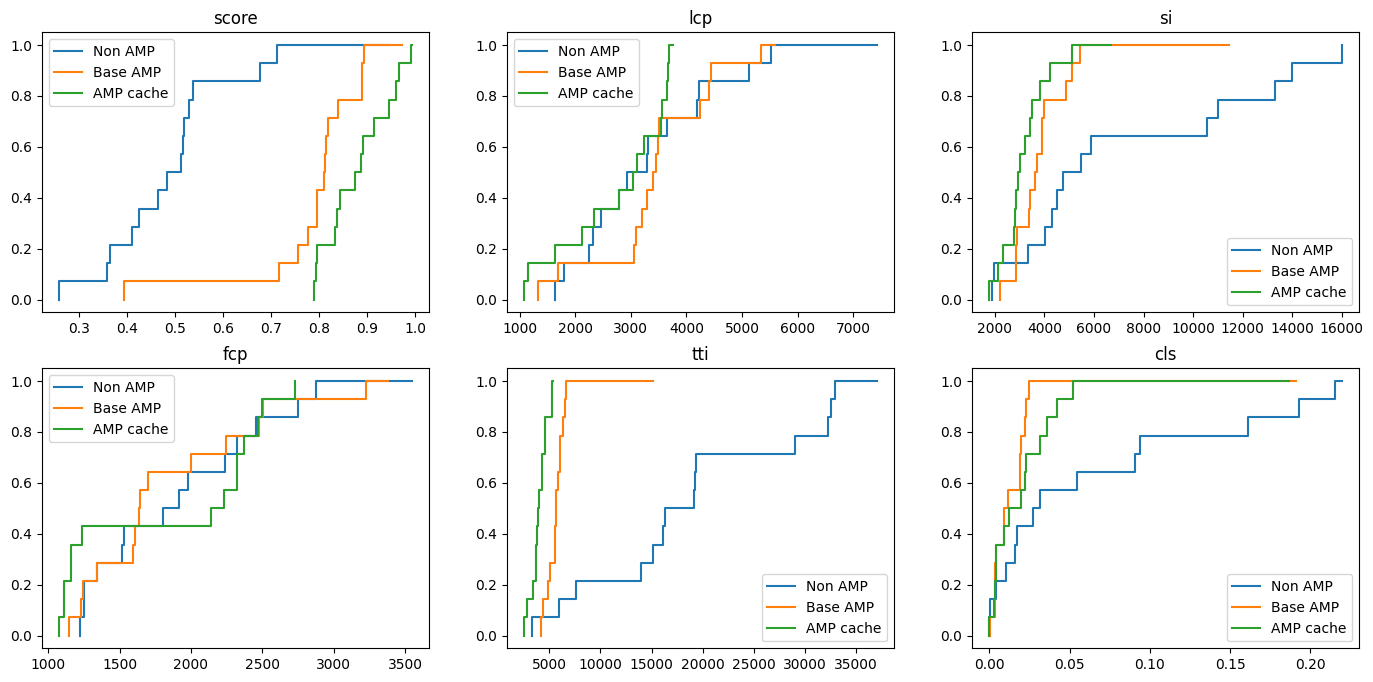

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(17,8))

for i, key in enumerate(keys[:6]):
    x, y = i % 2, i // 2
    ax[x, y].step(sorted(ordered[key][0]),np.linspace(0, 1, len(ordered[key][0])), label="Non AMP")
    ax[x, y].step(sorted(ordered[key][2]),np.linspace(0, 1, len(ordered[key][2])), label="Base AMP")
    ax[x, y].step( sorted(ordered[key][3]), np.linspace(0, 1, len(ordered[key][3])),label = "AMP cache")
    ax[x, y].set_title(key)
    ax[x, y].legend()
plt.show()

### 2.2 Comparaison page par page 

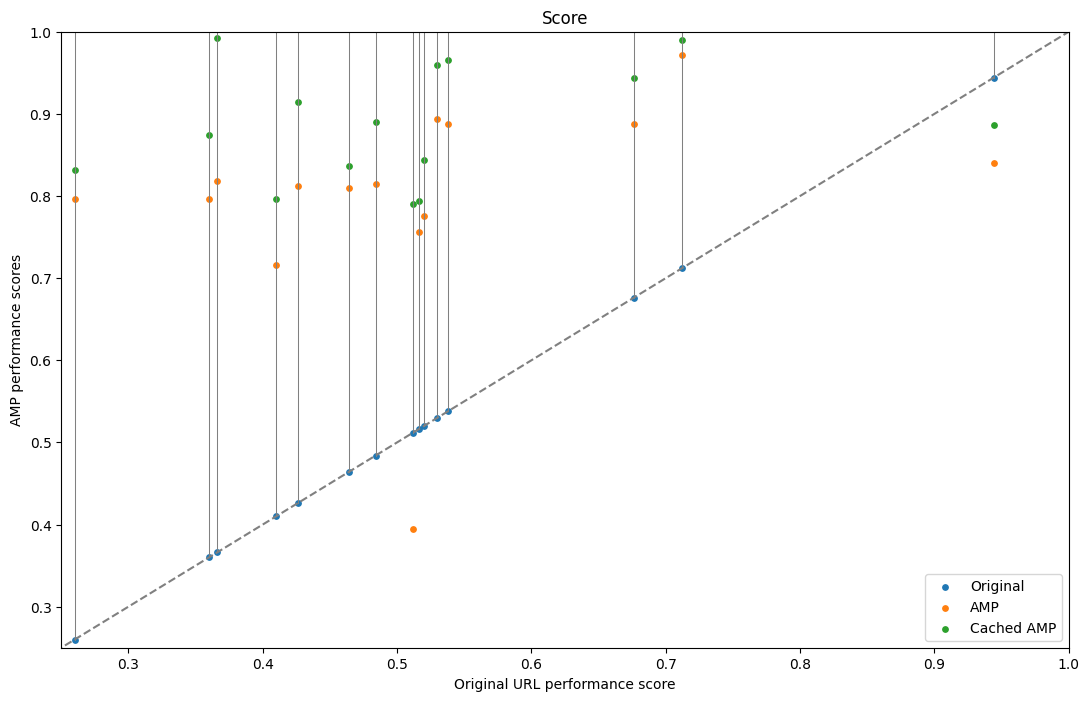

In [29]:
fig, ax = plt.subplots(figsize=(13,8))
for value in sorted(ordered["score"].values[0]): 
    plt.axvline(x=value, ymin=(value - 0.25) / 0.75, linewidth=0.75, c='gray')
    

plt.scatter(ordered["score"].values[0], ordered["score"].values[0], s=15,label="Original")
plt.scatter(ordered["score"].values[0], ordered["score"].values[1],s=15, label="AMP")
plt.scatter(ordered["score"].values[0], ordered["score"].values[2],s=15, label="Cached AMP")

plt.plot([0, 1], [0,1], linestyle='--', c= 'gray')
plt.xlim([0.25, 1])
plt.ylim([0.25, 1])
plt.title("Score")
plt.ylabel("AMP performance scores")
plt.xlabel("Original URL performance score")

plt.legend()
plt.show()

### 2.3 Comparaison par domaine 

In [33]:
grouped_audits.groupby(["domain", "page_type"])[keys].mean().head(6)

score        fcp        lcp           tti  \
domain            page_type                                              
fr.news.yahoo.com 0.0        0.512  2874.7558  3652.7884  13978.655200   
                  2.0        0.394  1340.7026  5344.6326  15172.295300   
                  3.0        0.790  1158.6436  3755.2728   5227.718000   
www.20minutes.fr  0.0        0.520  1803.4188  3294.1221  15190.136068   
                  2.0        0.776  1229.2546  4443.6045   5500.020000   
                  3.0        0.844  2371.0956  3673.0643   4026.702600   

                                       si       cls    fid  
domain            page_type                                 
fr.news.yahoo.com 0.0        11000.883053  0.016250  263.2  
                  2.0        11428.744553  0.000142  275.2  
                  3.0         6669.377334  0.000000  126.8  
www.20minutes.fr  0.0         4745.697184  0.054676  634.6  
                  2.0         3689.046557  0.022495  140.2  
                  3.0         3432.838366  0.022495   90.0

In [34]:
editor_data = grouped_audits.groupby(["domain", "page_type"])[["lcp", "fid", "cls", "score"]].mean().reset_index()
editor_data["page_type"] = editor_data["page_type"].map({0: "Canonique (HTML)", 2: "AMP", 3: "AMP (cache)"})

In [35]:
editor_data = editor_data[editor_data["domain"].isin([
    "www.allodocteurs.fr", "www.tf1info.fr", "www.ouest-france.fr", "www.lefigaro.fr", "www.bfmtv.com"
])].melt(id_vars=["domain", "page_type"])
editor_data = editor_data.set_index(["domain", "variable"])
best_in_class =editor_data.groupby(["domain", "variable"])["value"].min()
best_in_class_score =editor_data.groupby(["domain", "variable"])["value"].max()

In [36]:
editor_data["is_best"] = editor_data.apply(lambda x: best_in_class.loc[x.name] == x.value if x.name[1] != "score" else best_in_class_score.loc[x.name] == x.value , axis=1)
editor_data = editor_data.reset_index()
editor_data["anonymized_domain"] = editor_data["domain"].map({
    "www.allodocteurs.fr":"Éditeur A",
    "www.tf1info.fr":"Éditeur B",
    "www.ouest-france.fr": "Éditeur C", 
    "www.lefigaro.fr": "Éditeur D", 
    "www.bfmtv.com": "Éditeur E" 
})

In [37]:
alt.Chart(editor_data).encode(
    x = alt.X("page_type:O", title=None),
    y = alt.Y("value:Q", title=None),
    column=alt.Column("anonymized_domain:N",title=None),
    row=alt.Row("variable:N",title='Métrique'),
    color=alt.Color("page_type:N",title="Type de page"),
    opacity=alt.condition("datum.is_best", alt.value(1), alt.value(0.2))
).mark_bar().properties(width=90, height=100).resolve_scale(
    y = 'independent'
).properties(title="Étude de 4 métriques (CLS, FID, LCP, score de performance) pour 5 éditeurs de presse") 

alt.Chart(...)

In [38]:
relative_gain = np.array([1/1.04-1, 1/0.82-1] + [1/0.47-1,1/0.36-1] + [1/0.73-1,1/0.59-1] + [1/0.52-1,1/0.35-1])
df = pd.DataFrame({
    "Gain": 100 * relative_gain,
    "GainAbsolu": np.array([2016.48, 2016.48, 388, 388, 3919, 3919, 327, 327])* relative_gain,
    "page_type": ["AMP", "AMP (cache)"] * 4,
    "Métrique": (["Durée de chargement"] * 2 + ["Temps avant interactivité"] * 2) * 2,
    "HTML_type": ["Sites les plus rapides"] * 4 +["Sites les plus lents"] * 4
})


In [39]:
base1 = alt.Chart()
base2 = alt.Chart()

plot1 = base1.mark_bar(opacity=0.8, size=40).encode(
    y=alt.Y('Gain:Q', title='Gain (%)', axis=alt.Axis(grid=False), scale=alt.Scale(domain=[-25, 200])),
    color=alt.Color('Métrique:N'),
    x=alt.X('page_type:N', title=None, axis=alt.Axis(labelAngle=0)),
    #column = alt.Column("Métrique:O", spacing=0,header=alt.Header(labelAngle=0), title=None)
).properties(width=120, height=200)

plot2 = base2.mark_bar(opacity=0.8, size=40).encode(
    y=alt.Y('Gain:Q', title='Gain (%)',axis=alt.Axis(grid=False), scale=alt.Scale(domain=[-25, 200])),
    color='Métrique:N',
    x=alt.X('page_type:N', title=None, axis=alt.Axis(labelAngle=0))
).properties(width=120, height=200)


zero_line = alt.Chart().mark_rule(color="gray", strokeWidth=2).encode(y=alt.datum(0))
absolute_gains_plot = alt.Chart().mark_text().encode(
    x='page_type:N', 
    text="label:N", 
    y=alt.value(190), 
    color=alt.condition(
    "datum.GainAbsolu > 0", alt.value("green"), alt.value("red"))
                                          ).transform_calculate(label='format(datum.GainAbsolu,"d") + " ms"')

first_layer = (plot1 + zero_line + absolute_gains_plot).facet(
    column=alt.Column("Métrique:O",title=None, header=alt.Header(labels=False)), 
    spacing=0, 
    data=df[df["HTML_type"] == "Sites les plus rapides"]
).properties(title="Sites les plus rapides")

second_layer = (plot2 + zero_line + absolute_gains_plot).facet(
    column=alt.Column("Métrique:O",title=None, header=alt.Header(labels=False)), 
    spacing=0, 
    data=df[df["HTML_type"] == "Sites les plus lents"]
).properties(title="Sites les plus lents") 
(first_layer | second_layer).configure_title(
    align='right',
    font='Marianne'
)



alt.HConcatChart(...)